In [1]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import acquire as a
import prepare as p

In [2]:
df = a.get_all_data()
df = p.prep_store_data(df)

In [3]:
df = df.resample('w').agg('sum')

In [4]:
def split_store_data(df, train_prop=.66): 
    train_size = int(len(df) * train_prop)
    train, test = df[0:train_size], df[train_size:len(df)]
    return train, test

In [5]:
train, test = split_store_data(df, train_prop=.66)

In [6]:
print('Observations: %d' % (len(df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 261
Training Observations: 172
Testing Observations: 89


In [7]:
train = train[['sale_amount']]
test = test[['sale_amount']]

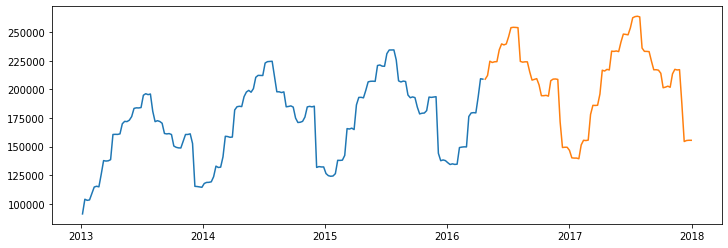

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(train)
plt.plot(test)
plt.show()

In [9]:
def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

In [10]:
def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train')
    plt.plot(test[target_vars], label='Test')

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()

In [11]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'metric', 'value'])
eval_df

,model_type,target_var,metric,value


In [12]:
def append_eval_df(model_type, target_vars, train = train, test = test):
    temp_eval_df = pd.concat([pd.DataFrame([[model_type, i, 'mse', evaluate(target_var = i, 
                                                                            train = train, 
                                                                            test = test, 
                                                                            output=False)[0]],
                                            [model_type, i, 'rmse', evaluate(target_var = i, 
                                                                             train = train, 
                                                                             test = test, 
                                                                             output=False)[1]]],
                                           columns=['model_type', 'target_var', 'metric', 'value']) 
                              for i in target_vars], ignore_index=True)
    return eval_df.append(temp_eval_df, ignore_index=True)

## Simple Average

In [13]:
yhat = pd.DataFrame(test.sale_amount)

In [14]:
yhat['y'] = train.sale_amount.mean()

In [15]:
mse = metrics.mean_squared_error(test['sale_amount'], yhat['y'])
rmse = math.sqrt(mse)
print(f"MSE: {mse}")
print(f"MSE: {rmse}")

MSE: 2691154814.91125
MSE: 51876.3415721584


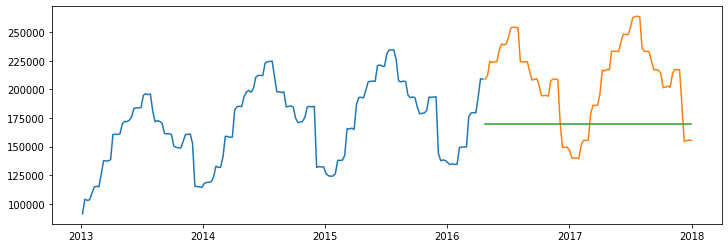

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(train['sale_amount'],label='Train')
plt.plot(test['sale_amount'], label='Test')
plt.plot(yhat['y'])
plt.show()

## Moveing Average

In [17]:
yhat['y'] = train.sale_amount.rolling(1).mean().iloc[-1]

In [18]:
mse = metrics.mean_squared_error(test['sale_amount'], yhat['y'])
rmse = math.sqrt(mse)
print(f"MSE: {mse}")
print(f"MSE: {rmse}")

MSE: 1157630494.247191
MSE: 34023.969407569


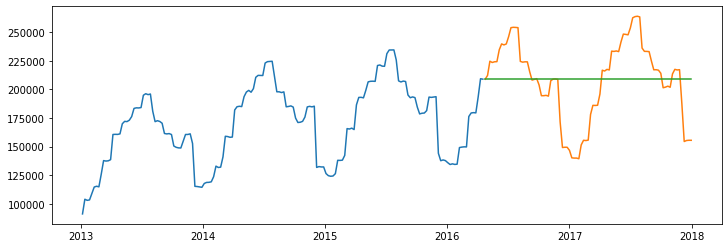

In [19]:
plt.figure(figsize=(12, 4))
plt.plot(train['sale_amount'],label='Train')
plt.plot(test['sale_amount'], label='Test')
plt.plot(yhat['y'])
plt.show()

## Holt Linear

In [20]:
model = Holt(train['sale_amount']).fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)

yhat['y'] = pd.DataFrame(model.forecast(test['sale_amount'].shape[0]), columns=['y'])

In [21]:
mse = metrics.mean_squared_error(test['sale_amount'], yhat['y'])
rmse = math.sqrt(mse)
print(f"MSE: {mse}")
print(f"MSE: {rmse}")

MSE: 32858251108.071705
MSE: 181268.45039353016


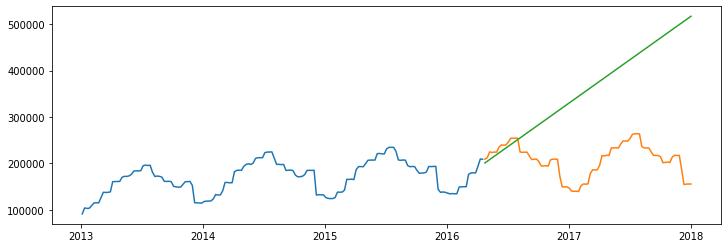

In [22]:
plt.figure(figsize=(12, 4))
plt.plot(train['sale_amount'],label='Train')
plt.plot(test['sale_amount'], label='Test')
plt.plot(yhat['y'])
plt.show()

## Predicting Based on the Previous Cycle

In [37]:
yhat['y'] = train['2015-04-26':'2016-04-17'] + train['2015-04-26':'2016-04-17'].diff(7).mean()

In [39]:
train1 = train['2015-04-20':'2016-04-19']
test1 = test['2016-04-20':'2017-04-20']

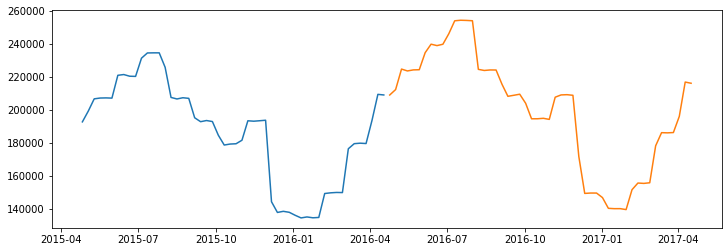

In [42]:
plt.figure(figsize=(12, 4))
plt.plot(train1['sale_amount'],label='Train')
plt.plot(test1['sale_amount'], label='Test')
#plt.plot(yhat['y'])
plt.show()

In [40]:
mse = metrics.mean_squared_error(train1['sale_amount'], yhat['y'])
rmse = math.sqrt(mse)
print(f"MSE: {mse}")
print(f"MSE: {rmse}")

ValueError: Found input variables with inconsistent numbers of samples: [89, 52]